In [1]:
import datetime
import os.path
import sys
import math

import backtrader as bt
import backtrader.indicators as btind
import pandas as pd
import pandas_market_calendars as mcal
import numpy as np
import pytz

In [3]:
!head ../data/raw/ES_tick_backadjusted.csv

## Preprocess Tick Data

In [2]:
path = '../data/raw/ES_tick_backadjusted.csv'
parse = lambda x: datetime.datetime.strptime(x[:-1],'%Y%m%d %H%M%S %f')
tick_data = pd.read_csv(path, delimiter=';',header=None, index_col='date', 
                        parse_dates=['date'],
                        date_parser=parse,
                        names=['date','last','bid','ask','volume'])

##Convert to EST
tick_data.index = tick_data.index.tz_localize('UTC')
tick_data = tick_data.tz_convert('US/Eastern')

##Save to feather format -- need to make index a column (won't take the datetime)
tick_data.reset_index(inplace=True)
tick_data.to_feather('../data/processed/ES_tick.feather')

In [19]:
tick_data.head()

,date,last,bid,ask,volume
0,2016-09-15 00:00:00.292000-04:00,2112.25,2112.25,2112.50,8
1,2016-09-15 00:00:01.425000-04:00,2112.50,2112.50,2112.75,1
2,2016-09-15 00:00:05.201000-04:00,2112.25,2112.25,2112.50,1
3,2016-09-15 00:00:05.201000-04:00,2112.25,2112.25,2112.50,1
4,2016-09-15 00:00:05.201000-04:00,2112.25,2112.25,2112.50,1


## Load Tick Data
(and take subset)

In [2]:
tick_data = pd.read_feather('../data/processed/ES_tick.feather')
tick_data_samp = tick_data[(tick_data['date'] > '2017-12-6') & 
                           (tick_data['date'] < '2017-12-7')]

In [3]:
#We hack the NYSE Calendar extending the close until 4:15
class CMERTHCalendar(mcal.exchange_calendar_nyse.NYSEExchangeCalendar):
    @property
    def close_time(self):
        return datetime.time(16, 15)

In [4]:
datapath = '../data/raw/ES_minute_backadjusted.csv'
df_data = pd.read_csv(datapath, delimiter=';',header=None, index_col='date', 
                      parse_dates=['date'],
                      names=['date','open','high','low','close','volume'])

#Convert to EST
df_data.index = df_data.index.tz_localize('UTC')
df_data = df_data.tz_convert('US/Eastern')

# Get market calendar
nyse = CMERTHCalendar()
schedule = nyse.schedule(start_date=df_data.index.min(), end_date=df_data.index.max())

#Filter out those bars that occur during RTH
df_data['dates'] = pd.to_datetime(df_data.index.to_datetime().date)
df_data['valid_date'] = df_data['dates'].isin(schedule.index)
df_data['valid_time'] = False
during_rth = df_data['valid_date'] & \
            (df_data.index > schedule.loc[df_data['dates'],'market_open']) & \
            (df_data.index <= schedule.loc[df_data['dates'],'market_close'])
df_data.loc[during_rth, 'valid_time'] = True
df_data = df_data[df_data['valid_time'] == True]
df_data.drop(['dates','valid_date','valid_time'], axis=1, inplace=True)

df_data.head(5)

,open,high,low,close,volume
date,,,,,
2005-09-07 09:31:00-04:00,1145.75,1146.00,1145.50,1145.50,1440
2005-09-07 09:32:00-04:00,1145.75,1145.75,1145.50,1145.75,972
2005-09-07 09:33:00-04:00,1145.75,1145.75,1145.25,1145.50,1803
2005-09-07 09:34:00-04:00,1145.75,1146.00,1145.50,1145.75,2309
2005-09-07 09:35:00-04:00,1146.00,1146.25,1145.75,1146.00,1376


In [5]:
df_data_samp = df_data[(df_data.index > '2017-12-1') & (df_data.index < '2017-12-3')]

### Pivots Indicator

In [6]:
class Pivots(bt.ind.PeriodN):
    lines = ('pivots_low','pivots_high','swings')
    plotinfo = dict(subplot=False)
    plotlines = dict(
        pivots_low=dict(ls='None', marker='.', markersize=4.0, color='blue', fillstyle='full'),
        pivots_high=dict(ls='None', marker='.', markersize=4.0, color='blue', fillstyle='full'),
        swings=dict(ls='-', marker='.', markersize=4.0, color='green', _skipnan=True)
    )
    params = (('period', 2),)
    
        
    def prenext(self):
        self.lower_low = False
        self.higher_high = False
        
        self.pivot1_found = False
        self.pivot1_was_low = False
        self.pivot1_index = 0
        self.pivot1_value = 0
        
        self.pivot2_found = False
        self.pivot2_was_low = False
        self.pivot2_index = 0
        self.pivot2_value = 0
        
    def next(self):
        if self.lower_low:
            if self.data.low[0] > self.data.low[-1]:
                self.l.pivots_low[-1] = self.data.low[-1]
                self.lower_low = False
        else:
            if self.data.low[0] < self.data.low[-1]:
                self.lower_low = True
                
        if self.higher_high:
            if self.data.high[0] < self.data.high[-1]:
                self.l.pivots_high[-1] = self.data.high[-1]
                self.higher_high = False
        else:
            if self.data.high[0] > self.data.high[-1]:
                self.higher_high = True
                
        
        #This is the first pivot that we find
        if not self.pivot1_found:
            #pivot is a high
            if not np.isnan(self.l.pivots_high[-1]) and np.isnan(self.l.pivots_low[-1]):
                self.pivot1_was_low = False
                self.pivot1_index = len(self)
                self.pivot1_found = True
                self.pivot1_value = self.l.pivots_high[-1]
                self.l.swings[-1] = self.l.pivots_high[-1]
            #pivot is a low
            elif not np.isnan(self.l.pivots_low[-1]) and np.isnan(self.l.pivots_high[-1]):
                self.pivot1_was_low = True
                self.pivot1_index = len(self)
                self.pivot1_found = True
                self.pivot1_value = self.l.pivots_low[-1]
                self.l.swings[-1] = self.l.pivots_low[-1]
            elif not np.isnan(self.l.pivots_low[-1]) and not np.isnan(self.l.pivots_high[-1]):
                pass #unique case where bar is both pivot high and low    
        
        elif self.pivot1_found and not self.pivot2_found:
            if not np.isnan(self.l.pivots_high[-1]) and np.isnan(self.l.pivots_low[-1]):
                if self.pivot1_was_low:
                    self.pivot2_was_low = False
                    self.pivot2_index = len(self)
                    self.pivot2_found = True
                    self.pivot2_value = self.l.pivots_high[-1]
                    self.l.swings[-1] = self.l.pivots_high[-1]
                elif self.l.pivots_high[-1] >= self.pivot1_value:
                    #update pivot1 if this is a higher high
                    self.l.swings[self.pivot1_index - len(self) - 1] = np.nan
                    self.pivot1_value = self.l.pivots_high[-1]
                    self.l.swings[-1] = self.l.pivots_high[-1]
            elif not np.isnan(self.l.pivots_low[-1]) and np.isnan(self.l.pivots_high[-1]):
                if not self.pivot1_was_low:
                    self.pivot2_was_low = True
                    self.pivot2_index = len(self)
                    self.pivot2_found = True
                    self.pivot2_value = self.l.pivots_low[-1]
                    self.l.swings[-1] = self.l.pivots_low[-1]
                elif self.l.pivots_low[-1] <= self.pivot1_value:
                    #update pivot1 if this is a lower low
                    self.l.swings[self.pivot1_index - len(self) - 1] = np.nan
                    self.pivot1_value = self.l.pivots_low[-1]
                    self.l.swings[-1] = self.l.pivots_low[-1]
            elif not np.isnan(self.l.pivots_low[-1]) and not np.isnan(self.l.pivots_high[-1]):
                #unique case where bar is both pivot high and low  
                self.pivot2_index = len(self)
                self.pivot2_found = True
                if not self.pivot1_was_low: #Pivot 1 was high, so we make Pivot2 a low
                    self.pivot2_was_low = True
                    self.pivot2_value = self.l.pivots_low[-1]
                    self.l.swings[-1] = self.l.pivots_low[-1]
                else: #Pivot 1 was low, so we make Pivot2 a high
                    self.pivot2_was_low = False
                    self.pivot2_value = self.l.pivots_high[-1]
                    self.l.swings[-1] = self.l.pivots_high[-1]
            
        elif self.pivot1_found and self.pivot2_found:
            if not np.isnan(self.l.pivots_high[-1]) and np.isnan(self.l.pivots_low[-1]):
                if self.pivot2_was_low: # 3 pivot sequence complete -- update p1 & p2 fields
                    self.pivot1_was_low = self.pivot2_was_low
                    self.pivot1_index = self.pivot2_index
                    self.pivot1_value = self.pivot2_value
                    self.pivot2_was_low = False
                    self.pivot2_index = len(self)
                    self.pivot2_value = self.l.pivots_high[-1]
                    self.l.swings[-1] = self.l.pivots_high[-1]
                elif self.l.pivots_high[-1] >= self.pivot2_value:
                    #update pivot2 if this is a higher high
                    self.l.swings[self.pivot2_index - len(self) - 1] = np.nan
                    self.pivot2_value = self.l.pivots_high[-1]
                    self.l.swings[-1] = self.l.pivots_high[-1]
            elif not np.isnan(self.l.pivots_low[-1]) and np.isnan(self.l.pivots_high[-1]):
                if not self.pivot2_was_low: #3 pivot seq complete
                    self.pivot1_was_low = self.pivot2_was_low
                    self.pivot1_index = self.pivot2_index
                    self.pivot1_value = self.pivot2_value
                    self.pivot2_was_low = True
                    self.pivot2_index = len(self)
                    self.pivot2_value = self.l.pivots_low[-1]
                    self.l.swings[-1] = self.l.pivots_low[-1]
                elif self.l.pivots_low[-1] <= self.pivot2_value:
                    #update pivot2 if this is a lower low
                    self.l.swings[self.pivot2_index - len(self) - 1] = np.nan
                    self.pivot2_value = self.l.pivots_low[-1]
                    self.l.swings[-1] = self.l.pivots_low[-1]
            elif not np.isnan(self.l.pivots_low[-1]) and not np.isnan(self.l.pivots_high[-1]):
                #unique case where bar is both pivot high and low      
                self.pivot1_was_low = self.pivot2_was_low
                self.pivot1_index = self.pivot2_index
                self.pivot1_value = self.pivot2_value
                self.pivot2_index = len(self)
                
                if not self.pivot2_was_low: #2nd pivot was a high so 3rd pivot is a low
                    self.pivot2_was_low = True
                    self.pivot2_value = self.l.pivots_low[-1]
                    self.l.swings[-1] = self.l.pivots_low[-1]
                else:  # 2nd pivot was low so 3rd pivot is a high
                    self.pivot2_was_low = False
                    self.pivot2_value = self.l.pivots_high[-1]
                    self.l.swings[-1] = self.l.pivots_high[-1]

### MyStrategy

In [7]:
class MyStrategy(bt.Strategy):
    params = dict(period=21)
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.datetime()
        print('%s, %s' % (dt.isoformat(), txt))
        #print(dt)
    
    def notify_order(self, order):
        print('{}: Order ref: {} / Type {} / Status {}'.format(
            self.data.datetime.datetime().isoformat(),
            order.ref, 'Buy' * order.isbuy() or 'Sell',
            order.getstatusname()))

        if order.status == order.Completed:
            self.holdstart = len(self)

        if not order.alive() and order.ref in self.orefs:
            self.orefs.remove(order.ref)

    def __init__(self):
        #ema = btind.ExponentialMovingAverage(self.data, period=self.params.period)
        self.orefs = list()  
        self.counter = 0
        dl = Pivots(self.data)
        
    def next(self):
        self.counter += 1
        if self.counter % 2000 == 0:
        
            if self.orefs:
                return #pending orders -- do nothing
        
            if not self.position:
                if self.data.close[0] == self.data.high[0]:
                    os = self.buy_bracket(limitprice=self.data.close[0]+2, 
                                          price=self.data.close[0], 
                                          stopprice=self.data.close[0]-2)
                elif self.data.close[0] == self.data.low[0]:
                    os = self.sell_bracket(limitprice=self.data.close[0]-2, 
                                          price=self.data.close[0], 
                                          stopprice=self.data.close[0]+2)
            else: #in the market
                #self.sell()
                pass # do nothing

### ZigZag Indicator

In [32]:
class ZigZag(bt.ind.PeriodN):
    '''
      Identifies Peaks/Troughs of a timeseries
    '''
    lines = (
        'trend', 'last_pivot_t', 'last_pivot_x', 'last_pivot_ago',
        'zigzag_peak', 'zigzag_valley', 'zigzag', 'last_zigzag',
    )

    # Fancy plotting name
    # plotlines = dict(logreturn=dict(_name='log_ret'))
    plotinfo = dict(
        subplot=False,
        plotlinelabels=True, plotlinevalues=True, plotvaluetags=True,
    )

    plotlines = dict(
        trend=dict(marker='', markersize=0.0, ls='', _plotskip=True),
        last_pivot_t=dict(marker='', markersize=0.0, ls='', _plotskip=True),
        last_pivot_x=dict(marker='', markersize=0.0, ls='', _plotskip=True),
        last_pivot_ago=dict(marker='', markersize=0.0, ls='', _plotskip=True),
        zigzag_peak=dict(marker='v', markersize=4.0, color='red',
                         fillstyle='full', ls=''),
        zigzag_valley=dict(marker='^', markersize=4.0, color='red',
                           fillstyle='full', ls=''),
        zigzag=dict(_name='zigzag', color='blue', ls='-', _skipnan=True),
        last_zigzag=dict(_name='last_zigzag', color='blue', ls='--', _skipnan=True),
    )

    # update value to standard for Moving Averages
    params = (
        ('period', 2),
        ('up_retrace', 0.1),
        ('dn_retrace', 0.1),
        ('bardist', 0.015),  # distance to max/min in absolute perc
    )

    def __init__(self):
        super(ZigZag, self).__init__()

        if not self.p.up_retrace:
            raise ValueError('Upward retracement should not be zero.')

        if not self.p.dn_retrace:
            raise ValueError('Downward retracement should not be zero.')

        if self.p.up_retrace < 0:
            self.p.up_retrace = -self.p.up_retrace

        if self.p.dn_retrace > 0:
            self.p.dn_retrace = -self.p.dn_retrace

        self.p.up_retrace = self.p.up_retrace / 100
        self.p.dn_retrace = self.p.dn_retrace / 100

        self.missing_val = float('nan')

    def prenext(self):
        self.lines.trend[0] = 0
        self.lines.last_pivot_t[0] = 0
        self.lines.last_pivot_x[0] = self.data[0]
        self.lines.last_pivot_ago[0] = 0
        self.lines.zigzag_peak[0] = self.missing_val
        self.lines.zigzag_valley[0] = self.missing_val
        self.lines.zigzag[0] = self.missing_val
        self.lines.last_zigzag[0] = self.missing_val

    def next(self):
        data = self.data
        trend = self.lines.trend
        last_pivot_t = self.lines.last_pivot_t
        last_pivot_x = self.lines.last_pivot_x
        last_pivot_ago = self.lines.last_pivot_ago
        zigzag_peak = self.lines.zigzag_peak
        zigzag_valley = self.lines.zigzag_valley
        zigzag = self.lines.zigzag
        last_zigzag = self.lines.last_zigzag

        x = data[0]
        r = x / last_pivot_x[-1] - 1
        curr_idx = len(data) - 1

        trend[0] = trend[-1]
        last_pivot_x[0] = last_pivot_x[-1]
        last_pivot_t[0] = last_pivot_t[-1]
        last_pivot_ago[0] = curr_idx - last_pivot_t[0]
        zigzag_peak[0] = self.missing_val
        zigzag_valley[0] = self.missing_val
        zigzag[0] = self.missing_val
        last_zigzag[0] = x

        if trend[-1] == 0:
            if r >= self.p.up_retrace:
                piv = last_pivot_x[0] * (1 - self.p.bardist)
                zigzag_valley[-int(last_pivot_ago[0])] = piv
                zigzag[-int(last_pivot_ago[0])] = last_pivot_x[0]
                trend[0] = 1
                last_pivot_x[0] = x
                last_pivot_t[0] = curr_idx
            elif r <= self.p.dn_retrace:
                piv = last_pivot_x[0] * (1 + self.p.bardist)
                zigzag_peak[-int(last_pivot_ago[0])] = piv
                zigzag[-int(last_pivot_ago[0])] = last_pivot_x[0]
                trend[0] = -1
                last_pivot_x[0] = x
                last_pivot_t[0] = curr_idx
        elif trend[-1] == -1:
            if r >= self.p.up_retrace:
                piv = last_pivot_x[0] * (1 - self.p.bardist)
                zigzag_valley[-int(last_pivot_ago[0])] = piv
                zigzag[-int(last_pivot_ago[0])] = last_pivot_x[0]
                trend[0] = 1
                last_pivot_x[0] = x
                last_pivot_t[0] = curr_idx
            elif x < last_pivot_x[-1]:
                last_pivot_x[0] = x
                last_pivot_t[0] = curr_idx
        elif trend[-1] == 1:
            if r <= self.p.dn_retrace:
                piv = last_pivot_x[0] * (1 + self.p.bardist)
                zigzag_peak[-int(last_pivot_ago[0])] = piv
                zigzag[-int(last_pivot_ago[0])] = last_pivot_x[0]
                trend[0] = -1
                last_pivot_x[0] = x
                last_pivot_t[0] = curr_idx
            elif x > last_pivot_x[-1]:
                last_pivot_t[0] = curr_idx
                last_pivot_x[0] = x

        idx = 1
        while idx < len(self.zigzag) and math.isnan(zigzag[-idx]):
            last_zigzag[-idx] = self.missing_val
            idx += 1

        if idx < len(self.data):
            last_zigzag[-idx] = zigzag[-idx]

## Run Test

In [7]:
cerebro = bt.Cerebro()
            
        
class NewStrategy(bt.Strategy):
    def __init__(self):
        ema = btind.ExponentialMovingAverage(self.data, period=21)
        atr = btind.ATR(self.data, period=21)
        #zigzag = ZigZag(self.datas[0], up_retrace=.05, dn_retrace=-.05, plot=True)
        dl = Pivots(self.data)
        #pass
    
cerebro.addstrategy(NewStrategy)

bt_data = bt.feeds.PandasDirectData(
    dataname=tick_data_samp,
    timeframe=bt.TimeFrame.Ticks,
    tz=pytz.timezone('US/Eastern'),
    datetime=1,
    open=2,
    high=2,
    low=2,
    close=2,
    volume=5,
    openinterest=-1)

bt_data2 = bt.feeds.PandasDirectData(
    dataname=df_data_samp,
    timeframe=bt.TimeFrame.Minutes,
    tz=pytz.timezone('US/Eastern'),
    openinterest=-1)

cerebro.resampledata(bt_data2,
                    timeframe=bt.TimeFrame.Minutes,
                    compression=5)

cerebro.broker.setcash(100000.0)
cerebro.addtz(pytz.timezone('US/Eastern'))
cerebro.addcalendar(CMERTHCalendar())
cerebro.broker.setcommission(commission=0, margin=2000.0, mult=50.0)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

#cerebro.addobserver(bt.observers.Broker)
#cerebro.addobserver(bt.observers.Trades)
#cerebro.addobserver(bt.observers.BuySell)
cerebro.run(stdstats=False)

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00


<IPython.core.display.Javascript object>


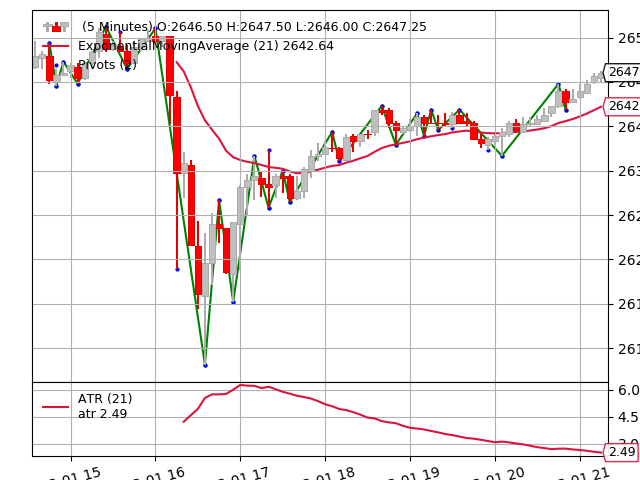

[[<matplotlib.figure.Figure at 0x7ff234968be0>]]

In [8]:
cerebro.plot(style='candle', volume=False, iplot=True)

In [8]:
!head ../data/raw/SPY_minute_last.csv

In [7]:
!head ../../../repos/backtrader/datas/orcl-1995-2014.txt

Date,Open,High,Low,Close,Adj Close,Volume
1995-01-03,2.179012,2.191358,2.117284,42.875004,2.117284,36301200
1995-01-04,2.123457,2.148148,2.092592,43.250004,2.135803,46051600
1995-01-05,2.141975,2.148148,2.086420,42.374996,2.092592,37762800
1995-01-06,2.092592,2.154321,2.061728,42.875004,2.117284,41864400
1995-01-09,2.135803,2.179012,2.129630,44.125000,2.179012,34639200
1995-01-10,2.191358,2.216049,2.185185,44.250000,2.185185,42088000
1995-01-11,2.203704,2.216049,2.098765,42.937500,2.120370,46762000
1995-01-12,2.123457,2.129630,2.086420,42.624996,2.104938,41294400
1995-01-13,2.129630,2.145062,2.074074,42.125000,2.080247,55039200


In [10]:
cerebro = bt.Cerebro()
path = '../../../repos/backtrader/datas/orcl-1995-2014.txt'
data = bt.feeds.YahooFinanceCSVData(
    dataname=path,
    # Do not pass values before this date
    fromdate=datetime.datetime(1995, 1, 1),
    # Do not pass values after this date
    todate=datetime.datetime(2000, 12, 31),
    reverse=False)
cerebro.adddata(data)
cerebro.broker.setcash(100000.0)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00


In [54]:
from scipy.signal import argrelmin

In [ ]:
argrelmin()